In [26]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [28]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [29]:
tf.__version__

'2.7.0'

In [30]:
ROOT = '/content/drive/MyDrive/Colab Notebooks/oss-project/'

In [31]:
data_dir = ROOT + 'PokemonData/'
train_dir = data_dir + 'train/'
test_dir = data_dir + 'test/'
validation_dir = data_dir + 'validation/'

In [32]:
train_data = os.listdir(train_dir)
test_data = os.listdir(test_dir)
validation_data = os.listdir(validation_dir)

In [33]:
# train_data.remove('.DS_Store')
# validation_data

In [34]:
n_classes = len(train_data)

In [35]:
def get_data_cnt(data, data_dir):
    cnt = 0

    for pokemon in data:
        cnt += len(os.listdir(data_dir + pokemon))

    return cnt

In [36]:
train_num = get_data_cnt(train_data, train_dir)
test_num = get_data_cnt(test_data, test_dir)
val_num = get_data_cnt(validation_data, validation_dir)
print('train 이미지 개수', train_num)
print('test 이미지 개수', test_num)
print('validation 이미지 개수', val_num)
print('포켓몬 종류', len(train_data))

train 이미지 개수 9691
test 이미지 개수 1127
validation 이미지 개수 1127
포켓몬 종류 151


In [42]:
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical')
val_generator = val_gen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 9691 images belonging to 151 classes.
Found 1127 images belonging to 151 classes.


94781440/94765736 [==============================] - 1s 0us/step


In [14]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [38]:
with tf.device('/device:GPU:0'):
    resnet = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3))
    model = tf.keras.Sequential()
    model.add(resnet)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))
    model.layers[0].trainable = False
    model.summary()
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    history = model.fit(
        train_generator,
        steps_per_epoch=train_num//64,  
        epochs=30,
        validation_data=val_generator,
        validation_steps=val_num//32,
        workers=8
    )

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_6   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 151)               309399    
                                                                 
Total params: 23,897,111
Trainable params: 309,399
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/30
151/151 [==============================] - 322s 2s/step - loss: 5.0332 - accuracy: 0.0163 - val_loss: 4.9107 - val_accuracy: 0.0286
Epoch 2/30
151/151 [==============================] - 69s 443ms/step - loss: 4.8524 - accur

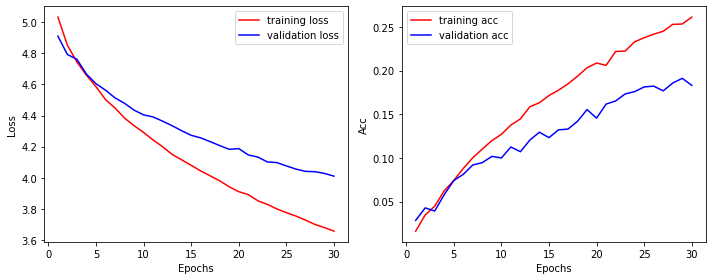

In [39]:
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 4))

plt.subplot(121)

plt.plot(epochs, loss, 'r', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs, acc, 'r', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir,
                              class_mode='categorical',
                              target_size=(224, 224))

Found 1127 images belonging to 151 classes.


In [46]:
pred = model.predict(test_generator)


NameError: ignored

In [47]:
import numpy as np

predicted_class_indices=np.argmax(pred, axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [50]:
import pandas as pd
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results

,Filename,Predictions
0,Abra/Abra20.jpg,Voltorb
1,Abra/Abra21.jpg,Exeggutor
2,Abra/Abra22.jpg,Diglett
3,Abra/Abra34.jpg,Venonat
4,Abra/Abra35.jpg,Sandslash
...,...,...
1122,Zubat/Zubat26.jpg,Muk
1123,Zubat/Zubat27.jpg,Eevee
1124,Zubat/Zubat31.jpg,Gengar
1125,Zubat/Zubat32.jpg,Psyduck


In [51]:
model.save(ROOT + 'resnet_fine_tuning.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
